# Query matching
In this notebook I will query images from the cornershop dataset and we will look for simular embeddings in the embedding gallary. The goal is to end up with a top 5,10 of matches.

In [1]:
%matplotlib inline

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid #imagegrids for visualizing the top 10 matches
import PIL
from PIL import Image
from load_vissl_model import load_model #self defined function to reconstruct a vissl model
from pathlib import Path

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Loading embedding gallary
First we'll load a vissl model to use for inference:

In [3]:
#Specify the model below! Possible options are:
#"rotnet", "jigsaw", "moco", "simclr" and "swav"
model_name = "jigsaw"
model = load_model(model_name, verbose=True)

#checking for the best device to run model on
device = torch.device("cpu") 
# if(torch.cuda.is_available()):
#     device = torch.device("cuda")
#     model.to(device) #move model to gpu
print(f"using {device} device", end="\n\n")

In function load_model()
Train config at (relative path from vissl/...):
validation/jigsaw_full/train_config.yaml
SSL pretrained weights at:
/home/olivier/Documents/master/mp/checkpoints/sku110k/jigsaw_full/model_final_checkpoint_phase104.torch


/home/olivier/Documents/master/mp/.venv/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive config/validation/jigsaw_full/train_config.yaml in pkg://configs.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)


Model jigsaw was succusfully build
Weights for model jigsaw succesfully loaded
using cpu device



Now let's load the embedding gallary for this model:

In [4]:
#Gallary is stored in data folder with model_name as subfolder
dir = Path("data/" + model_name)

#Load torch stack of features
fts_stack = torch.load(dir / "embedding_gallary.torch")
print(f"fts_stack has shape {fts_stack.shape}")
print(f"Minimum value {fts_stack.min()}\nMaximum value {fts_stack.max()}")
print(f"4 example tensors from this stack:\n{fts_stack[0:5]}", end="\n\n")

#Load torch stack of normalized features
fts_stack_norm = torch.load(dir / "embedding_gallary_norm.torch")
print(f"fts_stack_norm has shape {fts_stack_norm.shape}")
print(f"Minimum value {fts_stack_norm.min()}\nMaximum value {fts_stack_norm.max()}")
print(f"4 example tensors from this stack:\n{fts_stack_norm[0:5]}", end="\n\n")

#load label list
labels = list()
with open(dir / "embedding_gallary_labels.txt", "r") as f:
    labels = f.read().splitlines()
    print(f"labels list has length "+ str(len(labels)))
    print(f"4 examples from the label list are: {labels[0:4]}")

fts_stack has shape torch.Size([1643, 2048])
Minimum value 0.043427616357803345
Maximum value 1.5598208904266357
4 example tensors from this stack:
tensor([[0.7787, 0.7854, 0.5998,  ..., 0.5616, 0.7273, 0.7023],
        [0.7245, 0.7783, 0.5554,  ..., 0.5852, 0.7624, 0.7686],
        [0.7949, 0.5909, 0.5648,  ..., 0.4060, 0.7279, 0.7208],
        [0.7627, 0.6876, 0.4721,  ..., 0.5245, 0.7043, 0.7144],
        [0.8539, 0.8503, 0.6363,  ..., 0.6748, 0.7670, 0.7674]])

fts_stack_norm has shape torch.Size([1643, 2048])
Minimum value 0.0012697932543233037
Maximum value 0.04622628539800644
4 example tensors from this stack:
tensor([[0.0226, 0.0228, 0.0174,  ..., 0.0163, 0.0211, 0.0204],
        [0.0212, 0.0228, 0.0163,  ..., 0.0171, 0.0223, 0.0225],
        [0.0235, 0.0175, 0.0167,  ..., 0.0120, 0.0215, 0.0213],
        [0.0224, 0.0202, 0.0139,  ..., 0.0154, 0.0207, 0.0210],
        [0.0252, 0.0251, 0.0188,  ..., 0.0199, 0.0226, 0.0226]])

labels list has length 1643
4 examples from the label

## Quering an image from CornerShop

In [35]:
#inference function
def extract_features(img, model, verbose=False) -> torch.Tensor:
    """calculates the inference of an image using the model given. Returns the feature vector.

    Args:
        img (PIL.JpegImagePlugin.JpegImageFile): The image to feed to the neural net
        model (vissl model): Vissl model to use for inference.
        verbose (bool, optional): When True, you get prints from this function. Defaults to False.

    Returns:
        torch.Tensor: _description_
    """
    # Convert images to RGB. This is important
    # as the model was trained on RGB images.
    image = img.convert("RGB")

    # Image transformation pipeline.
    pipeline = transforms.Compose([
      transforms.Resize(256),
      #transforms.CenterCrop(255),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    #test time augmenting
    #take 10 crops
    width, height = image.size
    ten_crops=transforms.functional.ten_crop(image, size=(height/2, width/2)) 
    #push them through the transform pipeline
    transformed_crops = [pipeline(crop) for crop in ten_crops]

    #unsqueeze adds a dim for batch size (with 1 element the entire input tensor of the image)
    features = [model(x.unsqueeze(0))[0] for x in transformed_crops]

    #take the average embedding
    features_mean = torch.mean(torch.stack(features))
    
    if(verbose):
        print(f"Features extracted have the shape: { features_mean.shape }")
    return features[0]

Collect the images:

In [36]:
#path where images are stored 
CornerShop = Path("/home/olivier/Documents/master/mp/CornerShop/CornerShop/crops")
img_paths = CornerShop.glob("*/*.jpg")
query_idx = -1

Query idx is 1, labels[auery_idx]=CawstonDry
Reading image at /home/olivier/Documents/master/mp/CornerShop/CornerShop/crops/CawstonDry/p40_0126.jpg


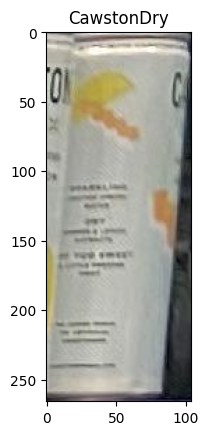

In [38]:
img_path = next(img_paths) #cycing trough the cornershop image dataset
query_idx+=1 #next label in list
label = img_path.parent.stem #extracting foldername as label for image
print(f"Query idx is {query_idx}, labels[auery_idx]={labels[query_idx]}")
print(f"Reading image at {img_path}")
img = Image.open(img_path)
plt.title(label)
plt.imshow(img)

Calculate the embedding with the vissl model:

In [39]:
img_fts = extract_features(img,model).squeeze()
print(f"feature vector has shape {img_fts.shape}")
print(f"The embedding vector looks like this: {img_fts}")

feature vector has shape torch.Size([2048])
The embedding vector looks like this: tensor([0.7596, 0.7378, 0.5787,  ..., 0.5235, 0.7429, 0.7037])


In [40]:
#calulating the normalized features for our image
norm = img_fts.norm(dim=0,keepdim=False)
img_fts_norm = img_fts / norm

## Matching the query embedding to the gallary
In summary we have:
- The calculated embedding `img_fts` of our query image (as a torch.Tensor)
- The calculated normalized embedding `img_fts_norm` of our query image (as a torch.Tensor)
- The `query_idx`, which represents the index of our query embedding in the gallary embedding
- The `label` containing the ground truth for classification
- The embedding gallary `fts_stack` (as a torch.Tensor)
- The normalized embedding gallary `fts_stack_norm` (as a torch.Tensor)

Our goal is to match the query embedding to the best match in the gallary

In [41]:
#Converting our gallary to numpy arrays
fts_stack_np = fts_stack.numpy()
fts_stack_norm_np = fts_stack_norm.numpy()
#Converting our img_fts to numpy array
img_fts_np = img_fts.numpy()
img_fts_norm_np = img_fts_norm.numpy()
print("Conversion to numpy arrays succesfull")
print(f"dtype fts_stack_np={type(fts_stack_np)}\ndtype fts_stack_norm_np={type(fts_stack_norm_np)}")
print(f"dtype img_fts_np={type(img_fts_np)}")
print(f"dtype img_fts_norm_np={type(img_fts_norm_np)}")

Conversion to numpy arrays succesfull
dtype fts_stack_np=<class 'numpy.ndarray'>
dtype fts_stack_norm_np=<class 'numpy.ndarray'>
dtype img_fts_np=<class 'numpy.ndarray'>
dtype img_fts_norm_np=<class 'numpy.ndarray'>


In [42]:
#visualization for the matching results:
def show_top10(top10):
    """ Makes an imagegrid of the top 10 matches:
        Args:
            top10 : Array with indicis of the top10 matching embeddings from the gallary
    """
    #visualizing the top10
    top10_matches = [list(CornerShop.glob("*/*.jpg"))[i] for i in top10]
    imgs = [Image.open(top10_matches[i]) for i in range(len(top10_matches))]
    #creating matlab figure
    fig = plt.figure(figsize=(10., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                     axes_pad=0.4,  # pad between axes in inch.
                     )
    i=1
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.set_title(f"Match #{i}")
        ax.imshow(im)
        i+=1

    plt.show()

### Inner product (ip)

In [43]:
#Calulating the inner product of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_np.shape} x fts_stack.T {fts_stack_np.T.shape}")
sim_vector_ip =  np.matmul(img_fts_np, fts_stack_np.T)  
#The simularity vector contains a score that expresses how simular the query embedding 
#for each embedding in the embedding gallary
print(f"The sim_vector_ip looks like this: {sim_vector_ip}")
print(f"min     {sim_vector_ip.min()}")
print(f"max     {sim_vector_ip.max()}")
print(f"avg     {sim_vector_ip.mean()}")
print(f"std dev {sim_vector_ip.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [1146.5928 1136.9115 1126.1373 ... 1121.3798 1139.5356 1126.316 ]
min     1092.0989990234375
max     1167.1866455078125
avg     1137.7559814453125
std dev 10.567358016967773


In [44]:
ip_argsort = np.argsort(sim_vector_ip, kind="quicksort")
ip_argsort = ip_argsort[::-1] #reverse order so best match is at the front of the array
#print("Top 10 matches with inner product as metric are:\n")
top10 = ip_argsort[0:10]
#print(top10, end="\n\n")

print("Top10 label matches:")
for rank,label_idx in enumerate(top10):
    print(f"{rank+1}.{labels[label_idx]}")
print(f"\nGroud Truth = {label}")

Top10 label matches:
1.FantaOrangeBlik6x330ml
2.RedBullOriginalBlik8x250ml
3.VittelCitroenMunt50cl
4.GiniBlik6x33cl
5.GiniZeroBlik
6.FantaOrangeBlik330ml
7.FantaOrangeNoCalBlik6x330ml
8.SpriteFles500ml
9.JustWater
10.Palm

Groud Truth = CawstonDry


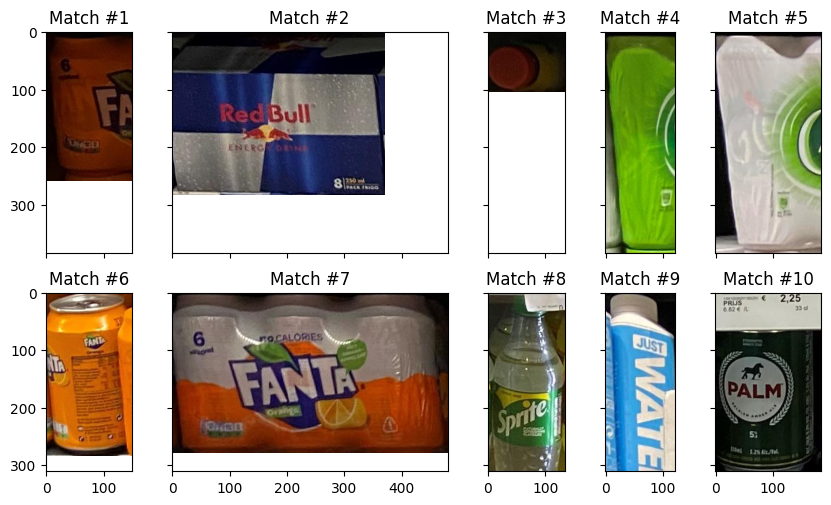

In [45]:
show_top10(top10=top10)

### Cosine simularity (cosim)

In [46]:
#Calulating the cosine simularity of the query and all the embeddings in the gallary
print(f"img_fts {img_fts_norm_np.shape} x fts_stack.T {fts_stack_norm_np.T.shape}")
sim_vector_cosim =  np.matmul(img_fts_norm_np, fts_stack_norm_np.T)  
print(f"The sim_vector_ip looks like this: {sim_vector_cosim}")
print(f"min     {sim_vector_cosim.min()}")
print(f"max     {sim_vector_cosim.max()}")
print(f"avg     {sim_vector_cosim.mean()}")
print(f"std dev {sim_vector_cosim.std()}")

img_fts (2048,) x fts_stack.T (2048, 1643)
The sim_vector_ip looks like this: [0.9950676  0.995565   0.9945965  ... 0.99492466 0.99515593 0.99488294]
min     0.9934811592102051
max     0.9961526989936829
avg     0.9951737523078918
std dev 0.000344012922141701


In [47]:
cosim_argsort = np.argsort(sim_vector_cosim, kind="quicksort")
cosim_argsort = cosim_argsort[::-1] #reverse order so best match is at the front of the array
#print("Top 10 matches with cosine simularity as metric are:")
top10 = cosim_argsort[0:10]
#print(top10, end="\n\n")

print("Top10 label matches:")
for rank,label_idx in enumerate(top10):
    print(f"{rank+1}.{labels[label_idx]}")
print(f"\nGroud Truth = {label}")

Top10 label matches:
1.NaluPassion6x350ml
2.ChaudfontaineFusionRaspberryLime
3.NaluPassion6x350ml
4.ArizonaLemonade
5.SpaLemonCucumber
6.ArizonaGreenTeaCitrus
7.CarrefourBioAnanassap
8.AquariusOrangeFles
9.SanPellegrino6x25cl
10.JupilerBlik6x35,5cl

Groud Truth = CawstonDry


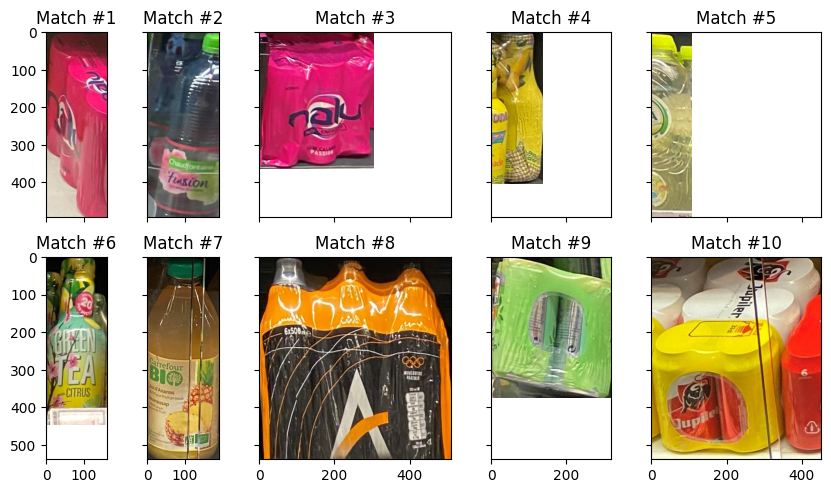

In [48]:
show_top10(top10=top10)